<div>
    <img src="https://cdn.pixabay.com/photo/2018/02/08/11/17/network-3139214_1280.jpg"/>
</div>

<h1 id="trouble" style="color:#FFFFFF; background:#46ABAA; border:0.5px dotted;"> 
    <center>Trouble shooting
        <a class="anchor-link" href="#trouble" target="_self"></a>
    </center>
</h1>

- When running on OneDrive the logging (tensorboard) did not work. An error occured saying that the logdir is not a directory.

<h1 id="versions" style="color:#FFFFFF; background:#46ABAA; border:0.5px dotted;"> 
    <center>Versions
        <a class="anchor-link" href="#versions" target="_self"></a>
    </center>
</h1>

Python 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]<br>
gym 0.21.0<br>
numpy 1.23.5<br>
pandas 1.5.3<br>
matplotlib 3.7.1<br>
stable_baselines3 1.7.0<br>
tensorflow 2.12.0<br>
keras 2.12.0<br>
openpyxl 3.1.2<br>

In [1]:
# Check your versions in case of problems.
import sys
import pkg_resources as pkg
print("Python", sys.version)
print("gym", pkg.get_distribution("gym").version)
print("numpy", pkg.get_distribution("numpy").version)
print("pandas", pkg.get_distribution("pandas").version)
print("matplotlib", pkg.get_distribution("matplotlib").version)
print("stable_baselines3", pkg.get_distribution("stable_baselines3").version)
print("tensorflow", pkg.get_distribution("tensorflow").version)
print("keras", pkg.get_distribution("keras").version)
print("openpyxl", pkg.get_distribution("openpyxl").version)

Python 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]
gym 0.21.0
numpy 1.23.5
pandas 1.5.3
matplotlib 3.7.1
stable_baselines3 1.7.0
tensorflow 2.12.0
keras 2.12.0
openpyxl 3.1.2


In [2]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from stable_baselines3 import SAC
# from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import TD3

# The following is used in DDPG and TD3
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise

<h1 id="dataset" style="color:#FFFFFF; background:#46ABAA; border:0.5px dotted;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self"></a>
    </center>
</h1>

# Load Data

In [4]:
# path = 'Datasets/0010_List_of_Repeating_Values.xlsx'
path = 'Datasets/0030_Det_Return_Sine.xlsx'

df = pd.read_excel(path)
df.head()

,Return
0,0.002998
1,0.003987
2,0.004955
3,0.005894
4,0.006794


# Split Data

In [5]:
Train_Ratio = 0.8
Train_Length = round(Train_Ratio * len(df))
Test_Length = len(df) - Train_Length
print('The length of the dataset is:', len(df))
print('The training set length is:', Train_Length)
print('The test set length is:', Test_Length)

The length of the dataset is: 150
The training set length is: 120
The test set length is: 30


In [6]:
df_train = df[0:Train_Length]
df_test = df[Train_Length:]

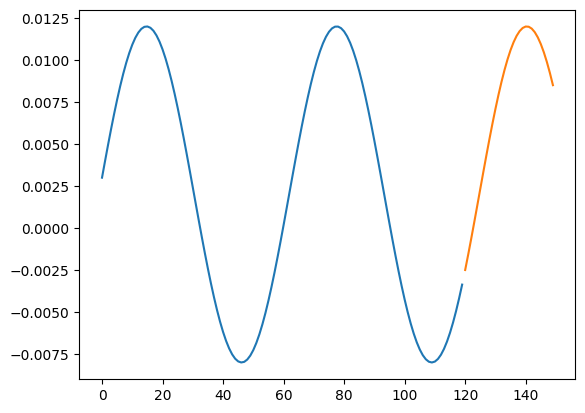

In [7]:
plt.plot(df_train.index, df_train.Return)
plt.plot(df_test.index, df_test.Return)

<h1 id="add_func" style="color:#FFFFFF; background:#46ABAA; border:0.5px dotted;"> 
    <center>Additional Functions
        <a class="anchor-link" href="#add_func" target="_self"></a>
    </center>
</h1>

In [8]:
# This function is for running the model and collect rewards, actions, and total return.
# All the collected information is saved in a dataframe.
# Also the buy-hold-strategy is added to the dataframe.

def deploy(env, model):
    state = env.reset()
    done = False
    
    tot_reward = 0
    i = 0

    i_List = [i]            # List with iteration
    Action_List = []        # List of actions, first action will be taken below   
    Reward_List = [None]    # List with rewards, first entry is None
    Tot_Reward_List = [0]   # List with total reward, we start at Zero

    Done_List = [False]
    Stock_Return_List = [state[0]]
                            # List with observed stock return, first column in data
    Stock_Price_List = [1]  # List with normalized stock price, starts with price of 1
    State_List = [state]    # List with observed states
      
    Stock_Investment_List = [0]
    Bank_Account_List = [InitialBank]
    
    
    
    while not done:
    
        i = i + 1
        i_List.append(i)
    
        action, _state = model.predict(state, deterministic=True)
        state, reward, done, info = env.step(action)
    
        Action_List.append(action)
        Reward_List.append(reward)
        State_List.append(state)
        
        tot_reward = tot_reward + reward
        Tot_Reward_List.append(tot_reward)
        
        Done_List.append(done)
        Stock_Return_List.append(state[0])
        Stock_Price_List.append(Stock_Price_List[-1]*(1+state[0]))
        
        Stock_Investment_List.append(env.StockValue_Out)
        Bank_Account_List.append(env.BankValue_Out)

     
    Action_List.append(None)
   
   
    ####### BUY AND HOLD ###########
    # In the following we also add the buy-and-hold strategy to the results
    
    state = env.reset()
    done = False
    action = 1
    
    tot_reward = 0
    Tot_Reward_Buy_Hold_List = [0] 
    
    
    while not done:
        state, reward, done, info = env.step(action)
        tot_reward = tot_reward + reward
        Tot_Reward_Buy_Hold_List.append(tot_reward)
    
    
    
    Result_Dict = {'Time': i_List,
                   'Return': Stock_Return_List,
                   'Price': Stock_Price_List,
                   'State': State_List,
                   'Action': Action_List,
                   'Stock Investment': Stock_Investment_List,
                   'Bank Account': Bank_Account_List,
                   'Done': Done_List,
                   'Reward': Reward_List,
                   'Total Reward': Tot_Reward_List,
                   'Buy Hold Total Reward': Tot_Reward_Buy_Hold_List}  

    
    Result_df = pd.DataFrame(Result_Dict) 
    

    return Result_df


In [9]:
from TradingPlots import Plot_Results

<h1 id="Environment" style="color:#FFFFFF; background:#46ABAA; border:0.5px dotted;"> 
    <center>Environment
        <a class="anchor-link" href="#Environment" target="_self"></a>
    </center>
</h1>

In [10]:
InitialBank = 10     # Initial wealth
Interest_Rate = 0.00  # Interest rate of bank account
transaction_cost_pct = 0.000

In [11]:
from TradingEnvironments import ContinuousTrading as ContEnv

env_train = ContEnv(df_train, InitialBank, Interest_Rate, transaction_cost_pct)
env_test = ContEnv(df_test, InitialBank, Interest_Rate, transaction_cost_pct)

C:\Users\denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
C:\Users\denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


<h1 id="A2C_model" style="color:#FFFFFF; background:#AF944B; border:0.5px dotted;"> 
    <center>A2C - Model 
        <a class="anchor-link" href="#A2C_model" target="_self"></a>
    </center>
</h1>

In [12]:
def train_A2C(env_train,
              model_name,
              timesteps = 1000,
              logdir = None):
    

    model = A2C('MlpPolicy',
                env_train, 
                gamma = 1,
                verbose = 1,
                tensorboard_log = logdir)
    
    start = time.time()    
    model.learn(total_timesteps = timesteps)
    end = time.time()

    model.save(f"models/{model_name}")
    print(' - Training time (A2C): ', (end - start) / 60, ' minutes')
    return model

In [13]:
for i in range(1,6):
    model_a2c = train_A2C(env_train, model_name="A2C_{}".format(i),
                          logdir = 'logs',
                          timesteps = 1000)
        

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\A2C_21
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | 1.03     |
| time/                 |          |
|    fps                | 588      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.41    |
|    explained_variance | 0.00643  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.331    |
|    std                | 0.994    |
|    value_loss         | 0.0903   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | 0.972    |
| time/                 |          |
|    fps                | 537   

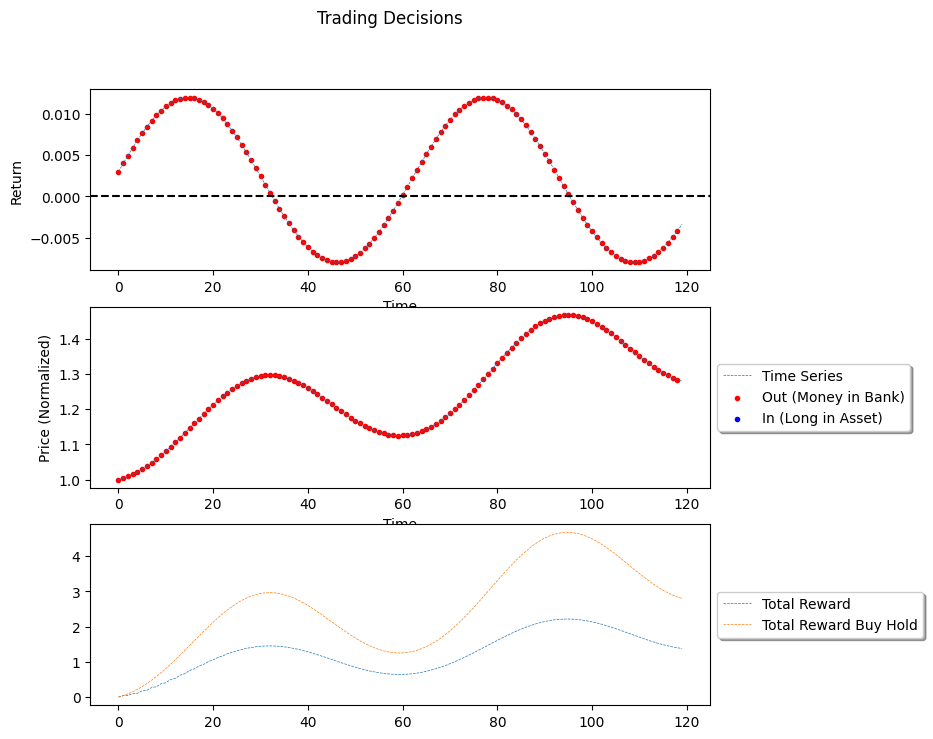

In [14]:
# Deploy the model on the training data
Train_Result_df = deploy(env_train, model_a2c)

# Plot the results
Plot_Results(Train_Result_df)

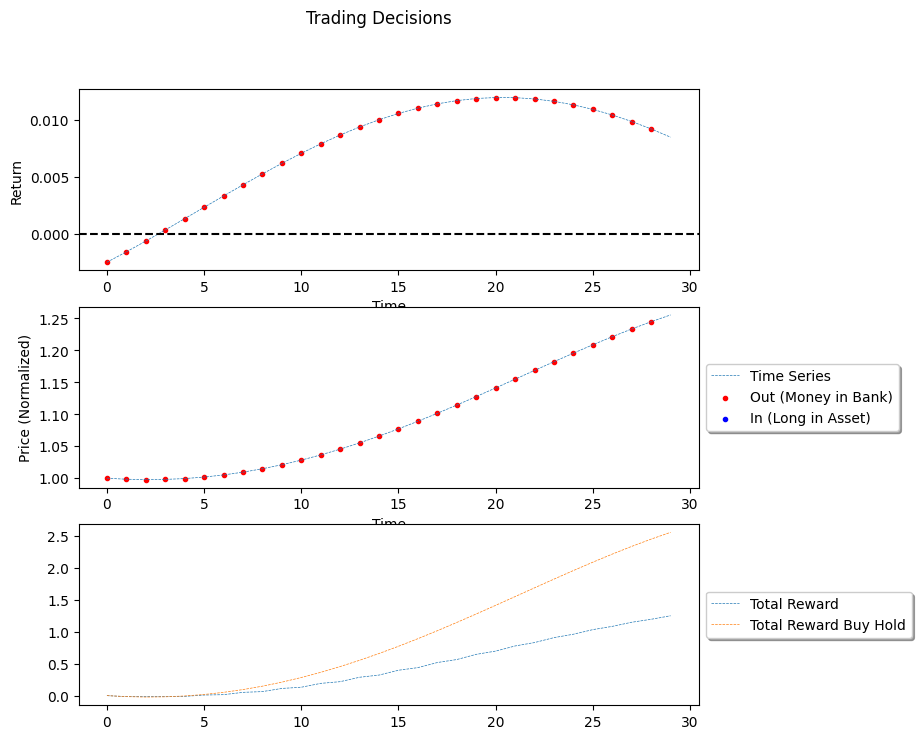

In [15]:
# Deploy the model on the test data
Test_Result_df = deploy(env_test, model_a2c)

# Plot the results
Plot_Results(Test_Result_df)

<h1 id="PPO_model" style="color:#FFFFFF; background:#9141B1; border:0.5px dotted;"> 
    <center>PPO - Model and Training
        <a class="anchor-link" href="#PPO_model" target="_self"></a>
    </center>
</h1>

In [16]:
def train_PPO(env_train, model_name, timesteps=1000, logdir = None):
    start = time.time()
    model = PPO('MlpPolicy', env_train, ent_coef = 0.005, verbose = 1, tensorboard_log = logdir)
    
    model.learn(total_timesteps=timesteps)
    
    end = time.time()

    model.save(f"models/{model_name}")
    print(' - Training time (PPO): ', (end - start) / 60, ' minutes')
    return model

In [17]:
for i in range(1,6):
    model_ppo = train_PPO(env_train, model_name="PPO_{}".format(i),
                          logdir = 'logs',
                          timesteps=500)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_11
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | 1.22     |
| time/              |          |
|    fps             | 1352     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
 - Training time (PPO):  0.05569378137588501  minutes
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_12
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | 1.13     |
| time/              |          |
|    fps             | 1381     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
 - Training time (PPO):  0.05299

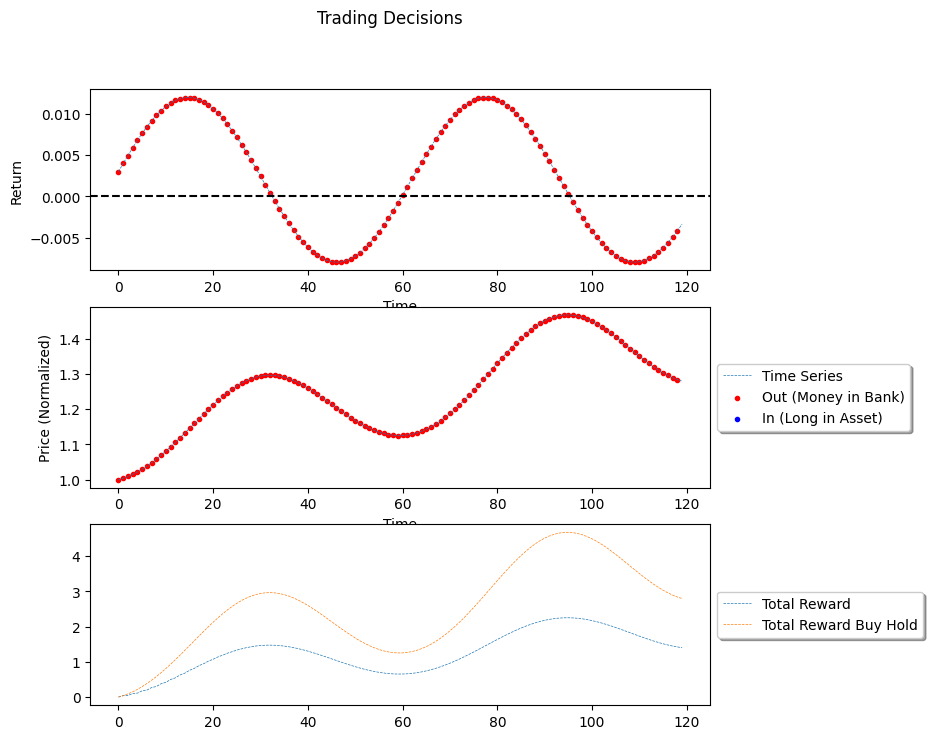

In [18]:
# Deploy the model on the training data
Train_Result_df = deploy(env_train, model_ppo)

# Plot the results
Plot_Results(Train_Result_df)

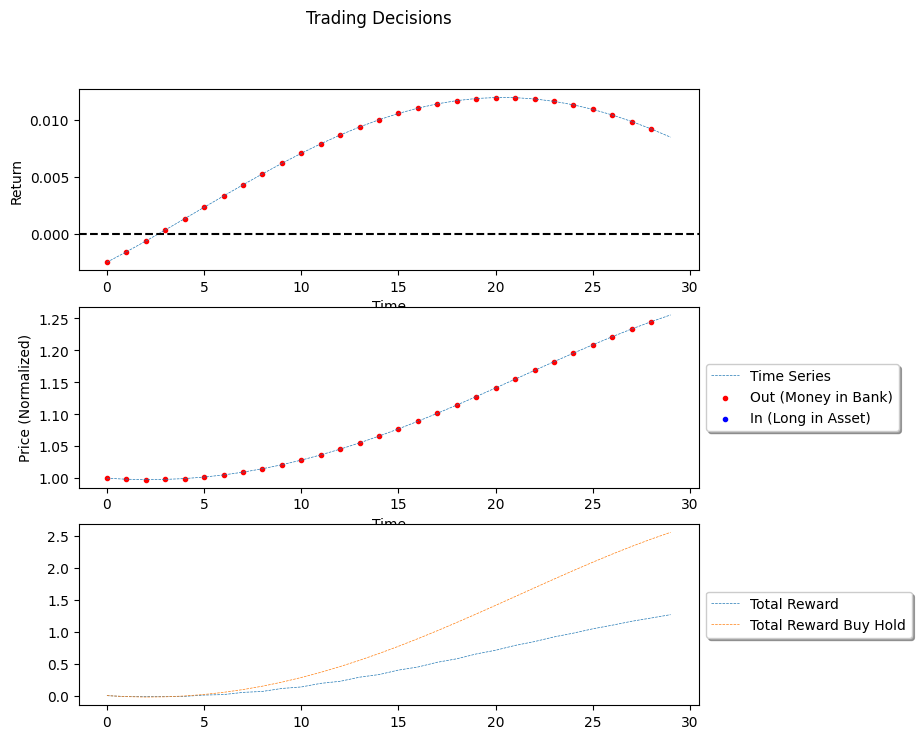

In [19]:
# Deploy the model on the test data
Test_Result_df = deploy(env_test, model_ppo)

# Plot the results
Plot_Results(Test_Result_df)

<h1 id="DDPG_model" style="color:#FFFFFF; background:#FF5733; border:0.5px dotted;"> 
    <center>DDPG
        <a class="anchor-link" href="#DDPG_model" target="_self"></a>
    </center>
</h1>

In [20]:
def train_DDPG(env_train, 
               model_name, 
               timesteps = 10000, 
               logdir = None):
    
    # add the noise objects for DDPG
    n_actions = env_train.action_space.shape[-1]
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

    model = DDPG('MlpPolicy',
                 env_train, 
                 action_noise=action_noise,
                 gamma = 1,
                 verbose = 1, 
                 tensorboard_log = logdir)
    
    start = time.time()    
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"models/{model_name}")
    print(' - Training time (DDPG): ', (end-start)/60,' minutes')
    return model

In [21]:
for i in range(1,6):
    model_ddpg = train_DDPG(env_train, model_name="DDPG_{}".format(i),
                            logdir = 'logs',
                            timesteps=500)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\DDPG_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | 2.41     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 91       |
|    time_elapsed    | 5        |
|    total_timesteps | 476      |
| train/             |          |
|    actor_loss      | -0.0718  |
|    critic_loss     | 0.00315  |
|    learning_rate   | 0.001    |
|    n_updates       | 357      |
---------------------------------
 - Training time (DDPG):  0.1395061691602071  minutes
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\DDPG_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | 2.45     |
| time/              |          |
|    episodes        | 4        

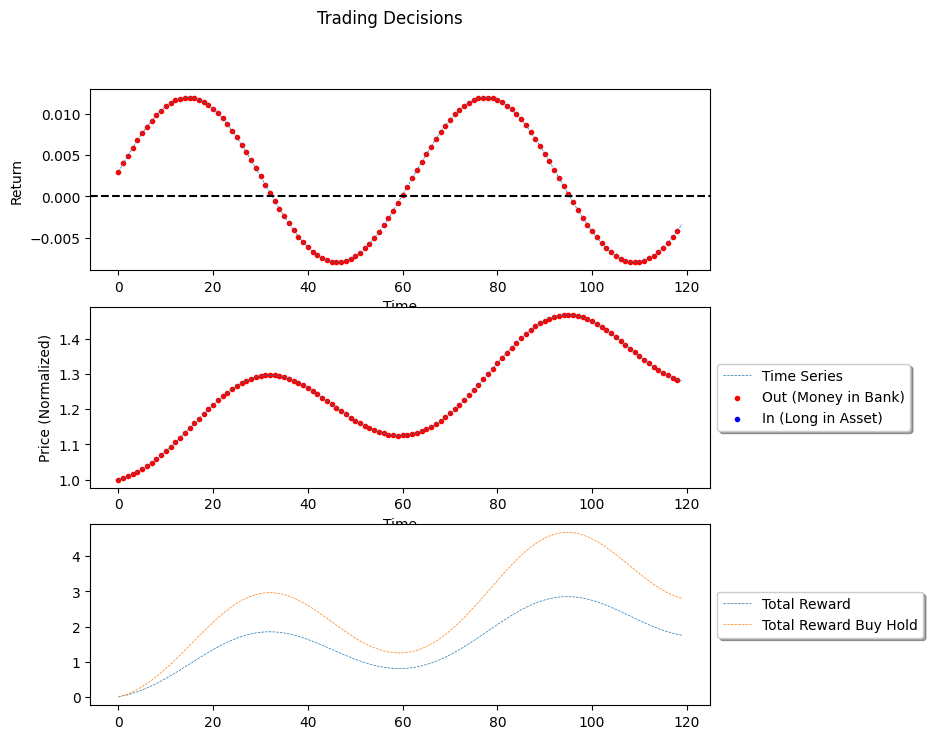

In [22]:
# Deploy the model on the training data
Train_Result_df = deploy(env_train, model_ddpg)

# Plot the results
Plot_Results(Train_Result_df)

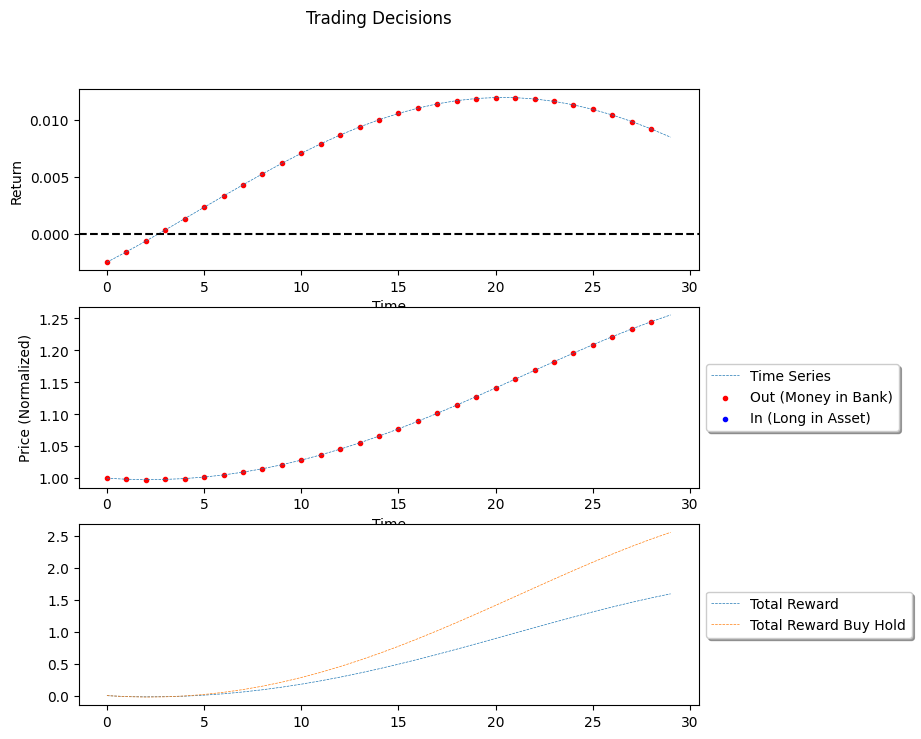

In [23]:
# Deploy the model on the test data
Test_Result_df = deploy(env_test, model_ddpg)

# Plot the results
Plot_Results(Test_Result_df)

<h1 id="SAC_model" style="color:#FFFFFF; background:#7A0614; border:0.5px dotted;"> 
    <center>Soft Actor Critic (SAC) 
        <a class="anchor-link" href="#SAC_model" target="_self">¶</a>
    </center>
</h1>

In [24]:
def train_SAC(env_train, 
              model_name, 
              timesteps = 10000, 
              logdir = None):
    

    model = SAC('MlpPolicy',
                env_train,
                gamma = 1,
                verbose = 1,
                tensorboard_log = logdir)
    
    start = time.time()
    model.learn(total_timesteps = timesteps)
    end = time.time()

    model.save(f"models/{model_name}")
    print(' - Training time (SAC): ', (end-start)/60,' minutes')
    return model

In [25]:
for i in range(1,6):
    model_sac = train_SAC(env_train, model_name="SAC_{}".format(i),
                          logdir = 'logs',
                          timesteps=500)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | 1.82     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 56       |
|    time_elapsed    | 8        |
|    total_timesteps | 476      |
| train/             |          |
|    actor_loss      | -2.32    |
|    critic_loss     | 0.0109   |
|    ent_coef        | 0.894    |
|    ent_coef_loss   | -0.187   |
|    learning_rate   | 0.0003   |
|    n_updates       | 375      |
---------------------------------
 - Training time (SAC):  0.15131423075993855  minutes
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\SAC_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | 1.8      |


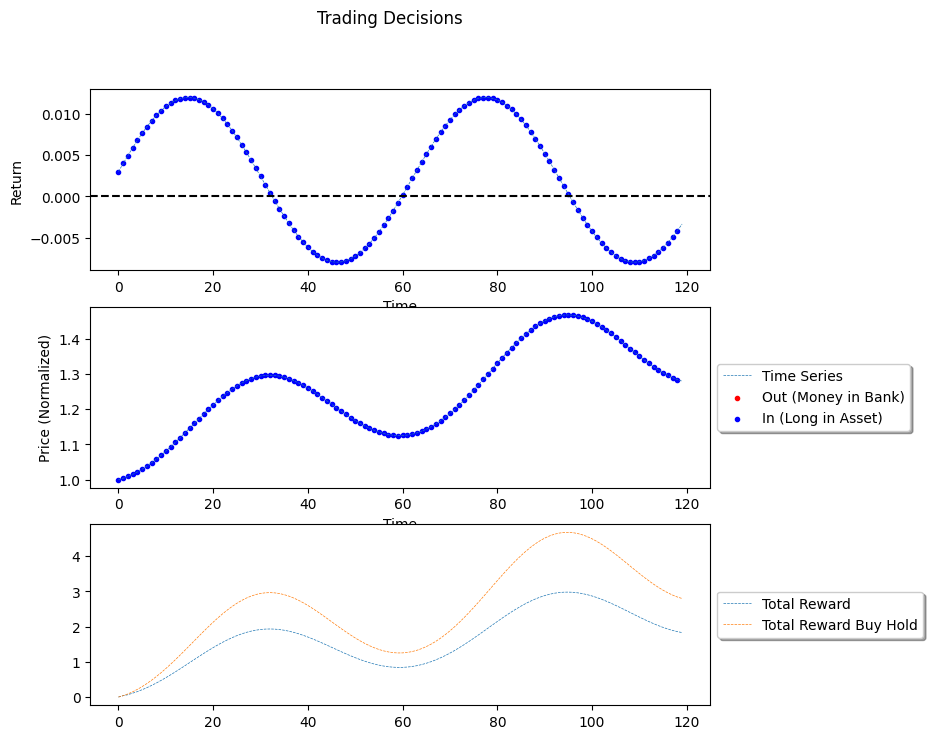

In [26]:
# Deploy the model on the training data
Train_Result_df = deploy(env_train, model_sac)

# Plot the results
Plot_Results(Train_Result_df)

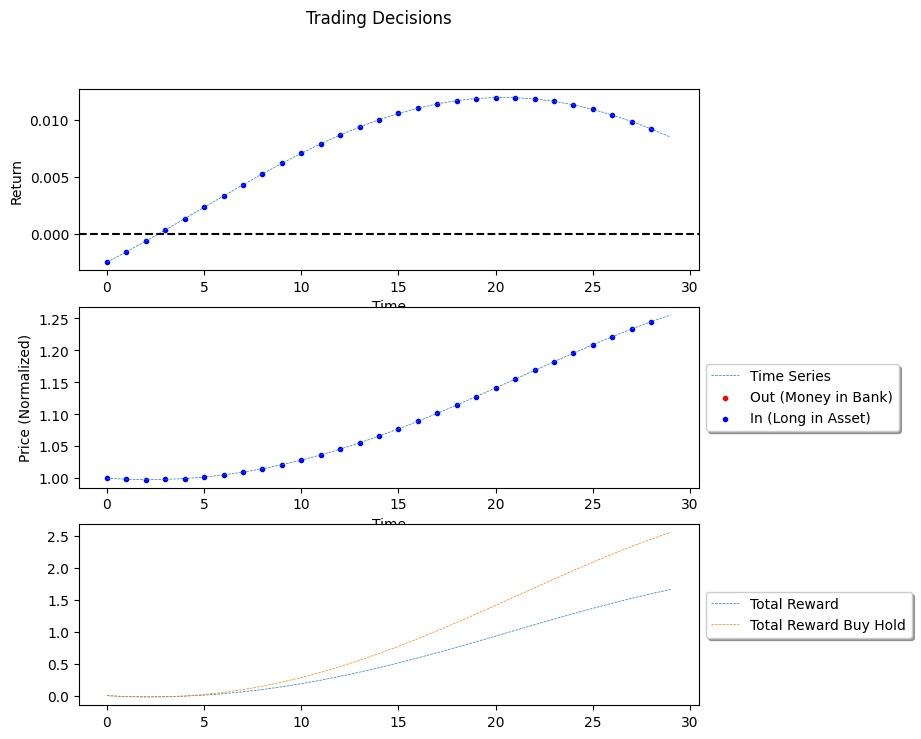

In [27]:
# Deploy the model on the test data
Test_Result_df = deploy(env_test, model_sac)

# Plot the results
Plot_Results(Test_Result_df)

<h1 id="TD3_model" style="color:#FFFFFF; background:#40067A; border:0.5px dotted;"> 
    <center>Twin Delayed DDPG (TD3)
        <a class="anchor-link" href="#TD3_model" target="_self"></a>
    </center>
</h1>

In [28]:
def train_TD3(env_train, 
              model_name, 
              timesteps = 10000, 
              logdir = None):
    
    # add the noise objects for DDPG
    n_actions = env_train.action_space.shape[-1]
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

    model = TD3('MlpPolicy', 
                env_train, 
                action_noise=action_noise,
                gamma = 1,
                verbose = 1, 
                tensorboard_log = logdir)
    
    start = time.time()
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"models/{model_name}")
    print(' - Training time (TD3): ', (end-start)/60,' minutes')
    return model

In [29]:
for i in range(1,6):
    model_td3 = train_TD3(env_train,
                          model_name = "TD3_{}".format(i),
                          logdir = 'logs',
                          timesteps = 500)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\TD3_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | 1.78     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 88       |
|    time_elapsed    | 5        |
|    total_timesteps | 476      |
| train/             |          |
|    actor_loss      | -0.109   |
|    critic_loss     | 0.00246  |
|    learning_rate   | 0.001    |
|    n_updates       | 357      |
---------------------------------
 - Training time (TD3):  0.14205362796783447  minutes
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\TD3_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | 2.53     |
| time/              |          |
|    episodes        | 4        |


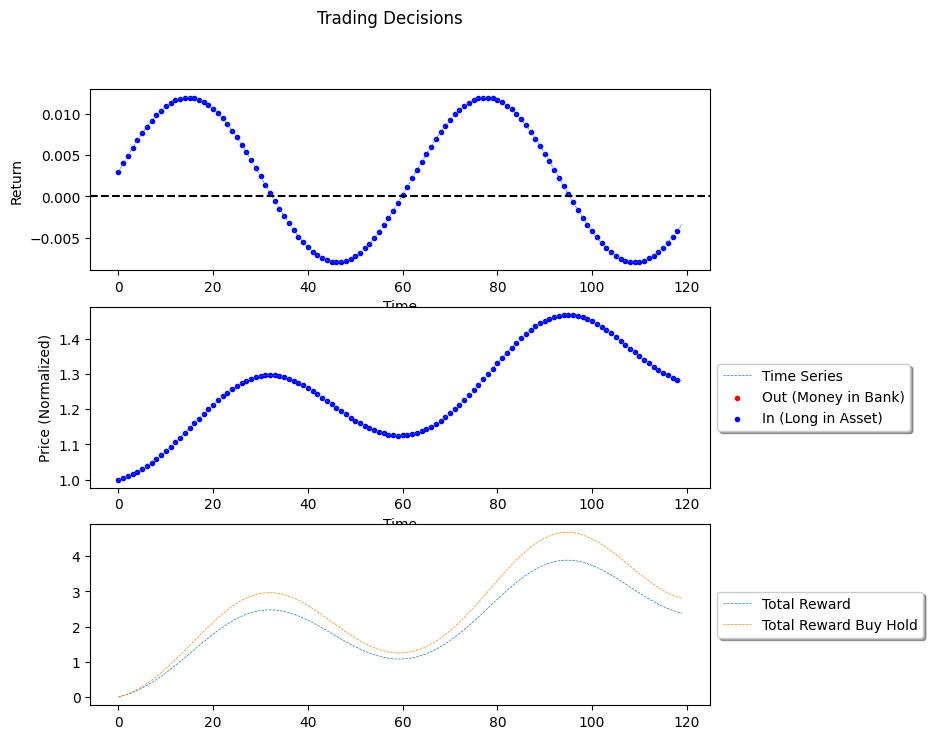

In [35]:
# Deploy the model on the training data
Train_Result_df = deploy(env_train, model_td3)

# Plot the results
Plot_Results(Train_Result_df)

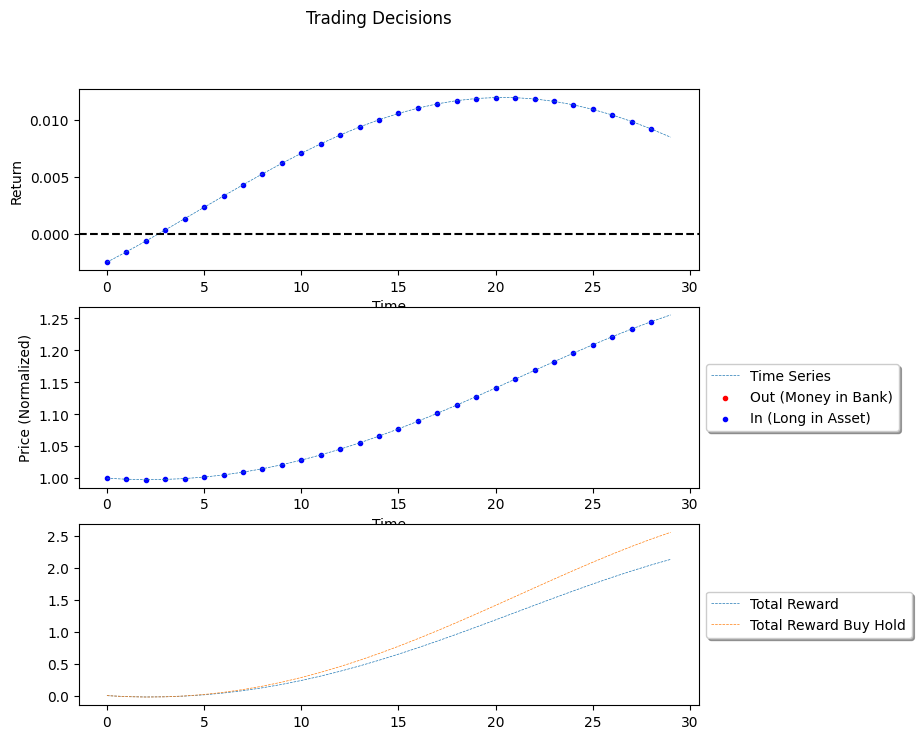

In [36]:
# Deploy the model on the test data
Test_Result_df = deploy(env_test, model_td3)

# Plot the results
Plot_Results(Test_Result_df)

<h1 id="Deploy" style="color:#FFFFFF; background:#F0A31C; border:0.5px dotted;"> 
    <center>Load and deploy model
        <a class="anchor-link" href="#Deploy" target="_self"></a>
    </center>
</h1>

In [37]:
# Here the desired model van be loaded
model_name="models/A2C_1"

In [38]:
# Here the desired model van be loaded
model = A2C.load(model_name, env = env_train)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


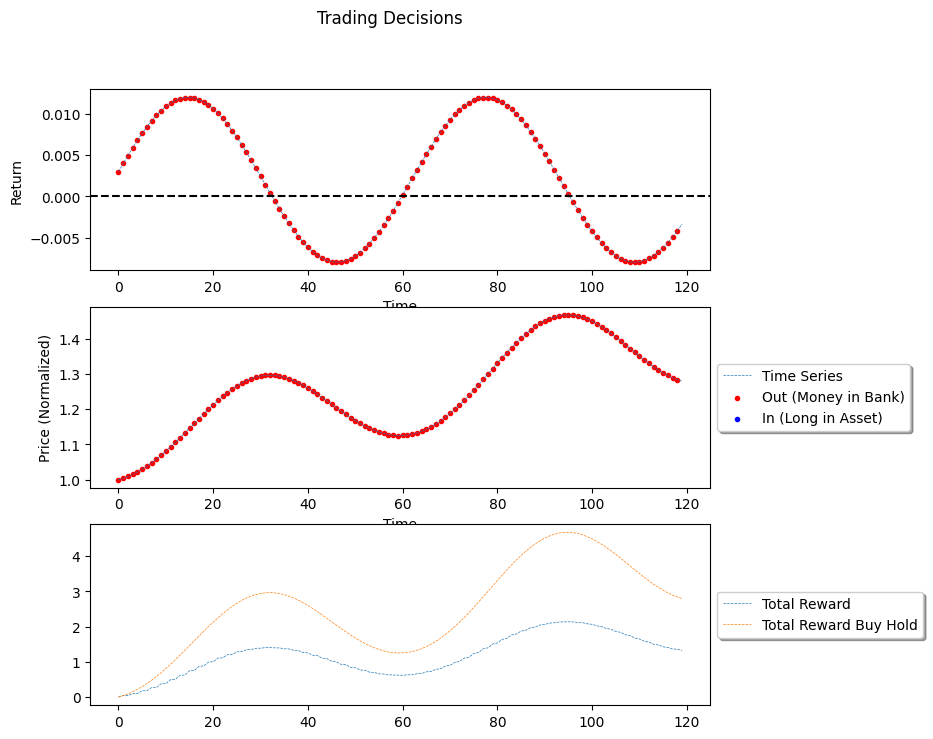

In [39]:
# Deploy the model on the training data
Train_Result_df = deploy(env_train, model)

# Plot the results
Plot_Results(Train_Result_df)